In [1]:
import os
import sys
import math
import time
import gzip
import random

import numpy as np
import pandas as pd
pd.set_option("display.max_columns",50)

import matplotlib.pyplot as plt
import seaborn as sns
PATH='~/Dropbox/cooperative/crystallinePolymer/data'

In [2]:
sample_list = pd.read_csv(os.path.join(PATH, 'SampleInfo.csv'), index_col=0, dtype={'CrystTemp': int, 'CrysTime': int, 'Cooling': bool})
sample_list['NucConc'] = sample_list['NucConc'].round(3)

## WAXD SAXSの補正 ##
データには結晶、非結晶による回折とairの値が混ざっている  
**まずは、airの部分を除去**  
方法は二つ  
**1**
peak_correct: airのpeakの高さで補正  
**2**
min_correct: airと比較して補正後にIntensityにマイナスが生まれないように補正

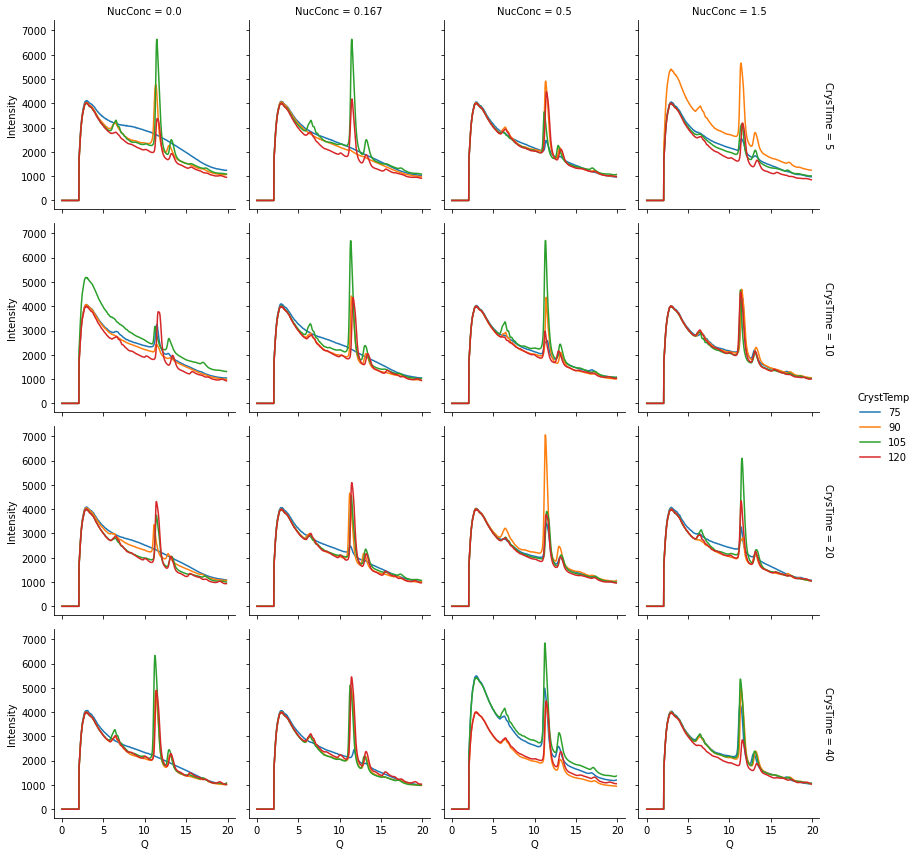

In [3]:
#WAXDのデータを取得
waxd =pd.read_table(PATH+str('/WAXD_rawdata/17.txt'), sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'Intensity'}).eval('SampleNo=17')
for id in range(18,81):
    wx=pd.read_table(PATH+str('/WAXD_rawdata/'+str(id)+'.txt'), sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'Intensity'}).eval('SampleNo='+str(id))
    waxd=waxd.append(wx, ignore_index=True)
    
waxd_data=waxd.merge(sample_list, how='left', left_on='SampleNo',right_index=True)
#print(waxd_data)
#waxd_data.to_csv(PATH+"/corrected_data/waxd_rawdata.csv")
##### 補正前 #####
grid = sns.FacetGrid(data=waxd_data, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'Intensity').add_legend()
plt.savefig("../fig/Xray_correction/WAXD_rawdata.pdf")

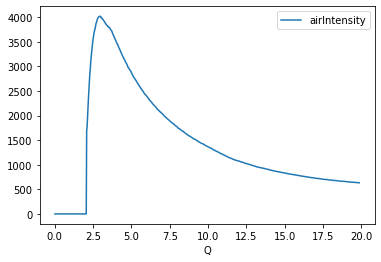

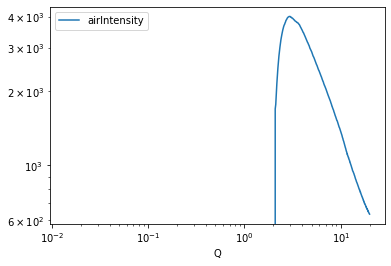

In [4]:
#WAXD airのデータ

wair=pd.read_table(PATH+"/WAXD_rawdata/air.txt", sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'airIntensity'}).eval('SampleNo=0')
wair.plot(x="Q",y="airIntensity")
plt.savefig("../fig/Xray_correction/WAXD_air.pdf")

wair.plot(x="Q",y="airIntensity")
plt.yscale('log')
plt.xscale('log')

               Q  SampleNo  CrystTemp  CrysTime  NucConc  peak_coef  \
0       0.013804        17         75         5      0.0   1.017719   
1       0.041412        17         75         5      0.0   1.017719   
2       0.069020        17         75         5      0.0   1.017719   
3       0.096628        17         75         5      0.0   1.017719   
4       0.124236        17         75         5      0.0   1.017719   
...          ...       ...        ...       ...      ...        ...   
46075  19.753452        80        120        40      1.5   0.987050   
46076  19.781061        80        120        40      1.5   0.987050   
46077  19.808668        80        120        40      1.5   0.987050   
46078  19.836277        80        120        40      1.5   0.987050   
46079  19.863884        80        120        40      1.5   0.987050   

       corrected_Intensity  
0                 0.000000  
1                 0.000000  
2                 0.000000  
3                 0.000000  
4 

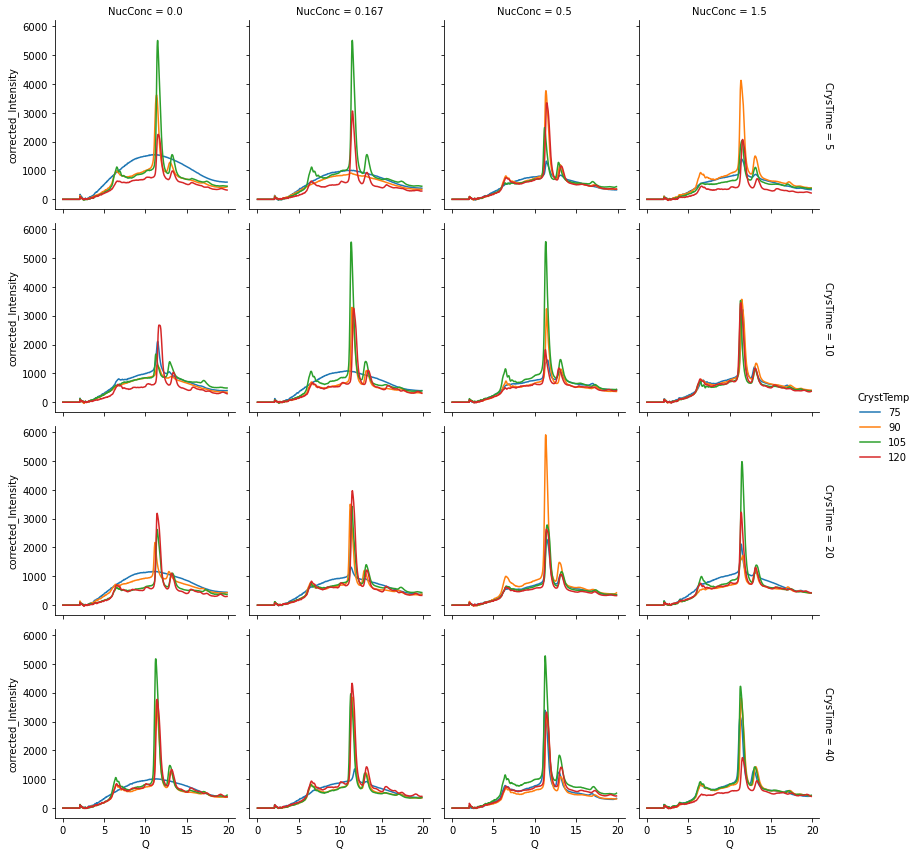

In [5]:
##### peak correct  (peakの高さで補正) #####
max_wair=wair.loc[wair.idxmax()['airIntensity']].filter(['Q','airIntensity'])
coef_list_wp = waxd[waxd['Q']==max_wair['Q']].eval('peak_coef=Intensity/@max_wair.airIntensity').filter(['SampleNo','peak_coef'])

peakcor_waxd=pd.merge(waxd_data, wair.drop("SampleNo",axis=1)).merge(coef_list_wp)\
    .eval('corrected_Intensity = Intensity- peak_coef * airIntensity')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
print(peakcor_waxd)
peakcor_waxd.to_csv(PATH+"/corrected_data/waxd_peakcorrect.csv")
#補正後
grid = sns.FacetGrid(data=peakcor_waxd, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()
plt.savefig("../fig/Xray_correction/WAXD_aircorrect.pdf")

               Q  SampleNo  CrystTemp  CrysTime  NucConc  min_coef  \
0       0.013804        17         75         5      0.0  1.017676   
64      0.041412        17         75         5      0.0  1.017676   
128     0.069020        17         75         5      0.0  1.017676   
192     0.096628        17         75         5      0.0  1.017676   
256     0.124236        17         75         5      0.0  1.017676   
...          ...       ...        ...       ...      ...       ...   
45823  19.753452        80        120        40      1.5  0.981695   
45887  19.781061        80        120        40      1.5  0.981695   
45951  19.808668        80        120        40      1.5  0.981695   
46015  19.836277        80        120        40      1.5  0.981695   
46079  19.863884        80        120        40      1.5  0.981695   

       corrected_Intensity  
0                 0.000000  
64                0.000000  
128               0.000000  
192               0.000000  
256           

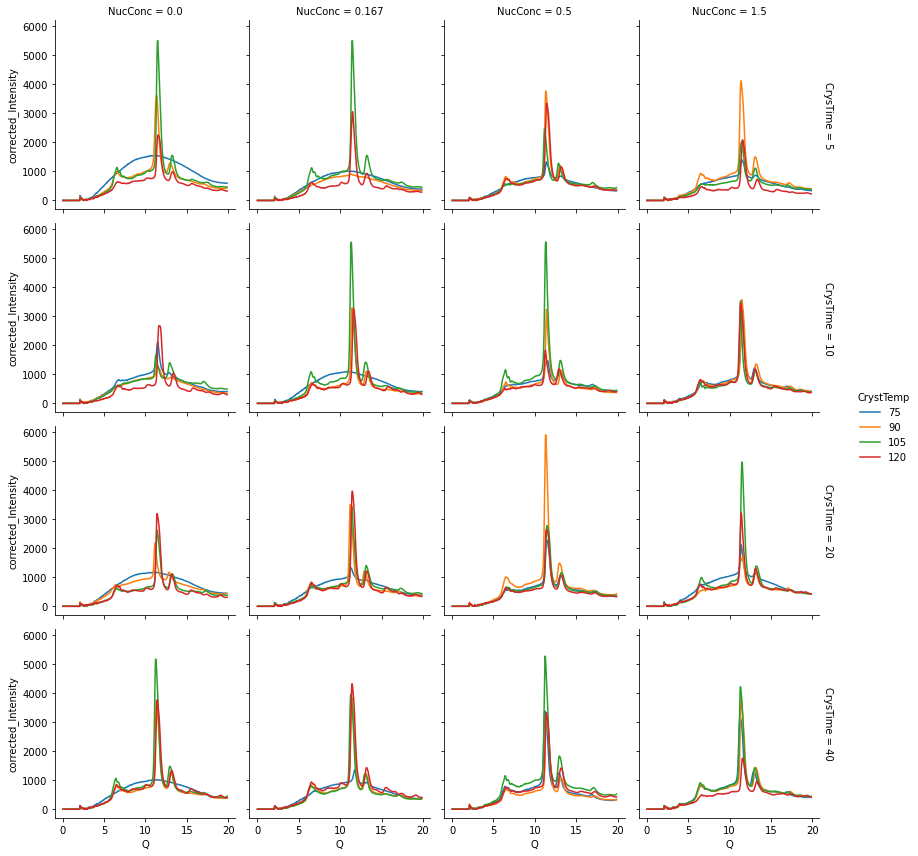

In [6]:
#####min correct (負のIntensityが生まれないように補正) #####
coef_list_wm=pd.merge(waxd_data, wair.drop("SampleNo",axis=1))\
    .eval("min_coef=Intensity/airIntensity").dropna()\
    .groupby('SampleNo').agg({'min_coef':min})

mincor_waxd=pd.merge(waxd_data, wair.drop("SampleNo",axis=1)).merge(coef_list_wm,left_on='SampleNo',right_index=True)\
    .eval('corrected_Intensity = Intensity- min_coef * airIntensity')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
print(mincor_waxd)
mincor_waxd.to_csv(PATH+"/corrected_data/waxd_mincorrect.csv")
#補正後
grid = sns.FacetGrid(data=mincor_waxd, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

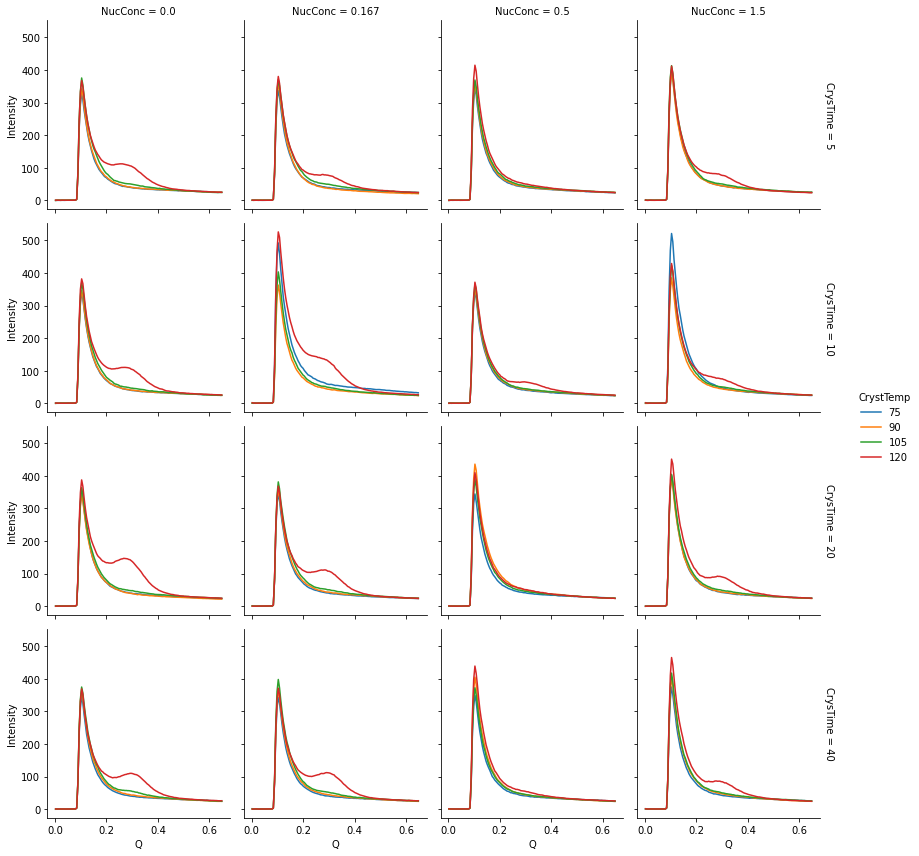

In [7]:
#SAXSのデータ取得
saxs =pd.read_table(PATH+str('/SAXS_rawdata/17.txt'), sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'Intensity'}).eval('SampleNo=17')
for id in range(18,81):
    sx=pd.read_table(PATH+str('/SAXS_rawdata/'+str(id)+'.txt'), sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'Intensity'}).eval('SampleNo='+str(id))
    saxs=saxs.append(sx, ignore_index=True)
    
saxs_data=saxs.merge(sample_list, how='left', left_on='SampleNo',right_index=True)
#print(saxs_data)
#saxs_data.to_csv(PATH+"/corrected_data/saxs_rawdata.csv")

##### 補正前 #####
grid = sns.FacetGrid(data=saxs_data, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'Intensity').add_legend()
plt.savefig("../fig/Xray_correction/SAXS_rawdata.pdf")

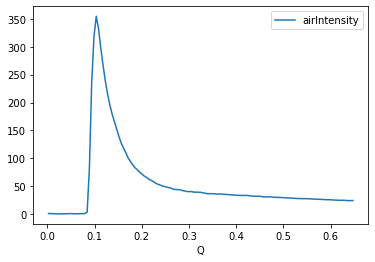

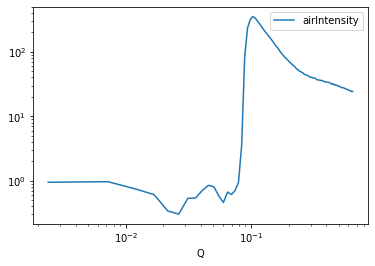

In [8]:
#SAXS airのデータ
sair=pd.read_table(PATH+"/SAXS_rawdata/air.txt", sep=' ', skiprows=3).astype(float).iloc[:,[1,3]]\
        .rename(columns={'Unnamed: 1': 'Q', 'Unnamed: 3': 'airIntensity'}).eval('SampleNo=0')
sair.plot(x="Q",y="airIntensity")
plt.savefig("../fig/Xray_correction/SAXS_air.pdf")

sair.plot(x="Q",y="airIntensity")
plt.yscale('log')
plt.xscale('log')

                21         156        291        426      561       696   \
SampleNo   17.000000  18.000000  19.000000  20.000000  21.0000  22.00000   
peak_coef   0.926725   0.949821   0.969854   1.124905   0.9557   1.38752   

                831        966        1101       1236      1371       1506  \
SampleNo   23.000000  24.000000  25.000000  26.000000  27.00000  28.000000   
peak_coef   0.963826   1.469066   0.990357   0.972384   0.97147   1.130931   

                1641       1776       1911       2046       2181       2316  \
SampleNo   29.000000  30.000000  31.000000  32.000000  33.000000  34.000000   
peak_coef   0.970864   0.968927   0.986154   1.056735   0.964639   1.013317   

                2451       2586       2721       2856       2991       3126  \
SampleNo   35.000000  36.000000  37.000000  38.000000  39.000000  40.000000   
peak_coef   1.006072   1.096228   0.975599   1.022926   0.983882   1.085384   

                3261  ...       5286       5421       5556  

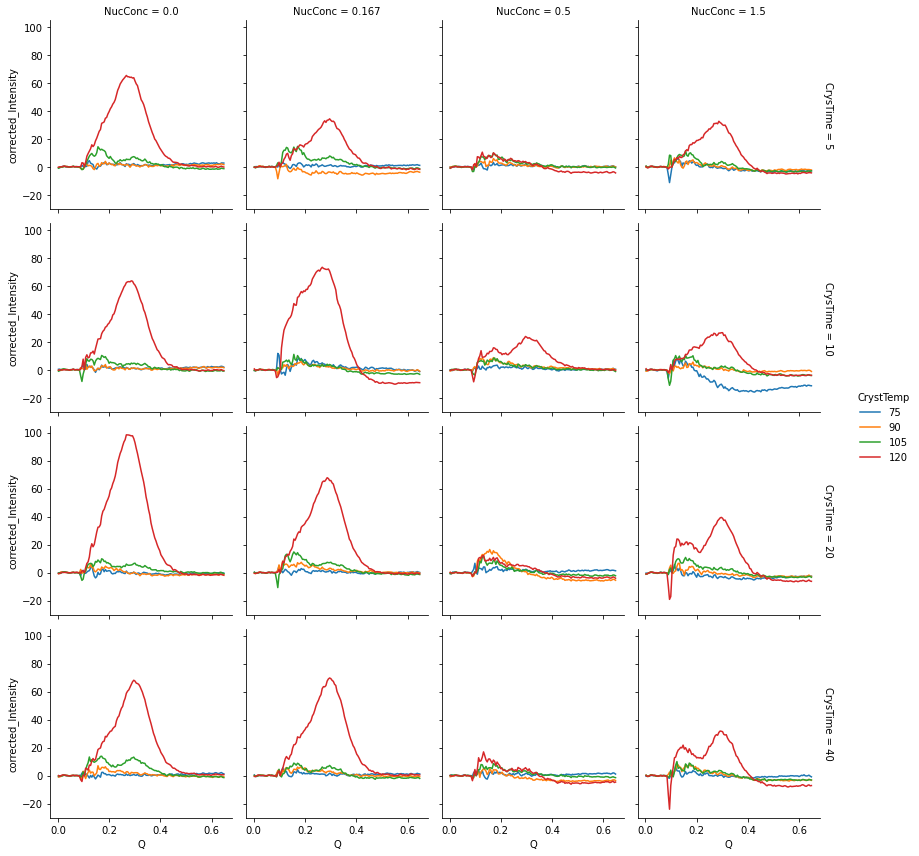

In [9]:
##### peak correct  (controlのpeakの高さで補正) #####
max_sair=sair.loc[sair.idxmax()['airIntensity']].filter(['Q','airIntensity'])

coef_list_sp = saxs[saxs['Q']==max_sair['Q']].eval('peak_coef=Intensity/@max_sair.airIntensity').filter(['SampleNo','peak_coef'])
print(coef_list_sp.T)

peakcor_saxs=pd.merge(saxs_data, sair.drop("SampleNo",axis=1)).merge(coef_list_sp)\
    .eval('corrected_Intensity = Intensity- peak_coef * airIntensity')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
peakcor_saxs.to_csv(PATH+"/corrected_data/saxs_peakcorrect.csv")
#補正後
grid = sns.FacetGrid(data=peakcor_saxs, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()
plt.savefig("../fig/Xray_correction/SAXS_aircorrecrt.pdf")

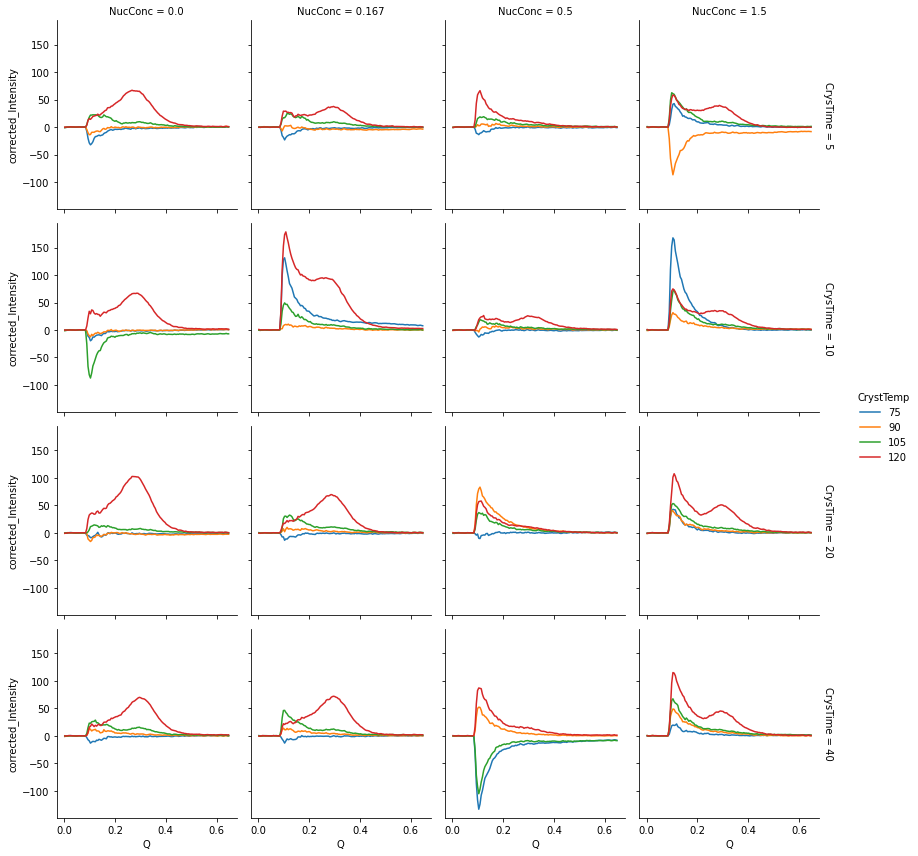

In [10]:
##### WAXD の補正で使用した係数を使ってみると？　#####
peakcor_saxs=pd.merge(saxs_data, sair.drop("SampleNo",axis=1)).merge(coef_list_wp)\
    .eval('corrected_Intensity = Intensity-  airIntensity * peak_coef')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
peakcor_saxs.to_csv(PATH+"/corrected_data/saxs_peakcorrect.csv")
#補正後
grid = sns.FacetGrid(data=peakcor_saxs, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

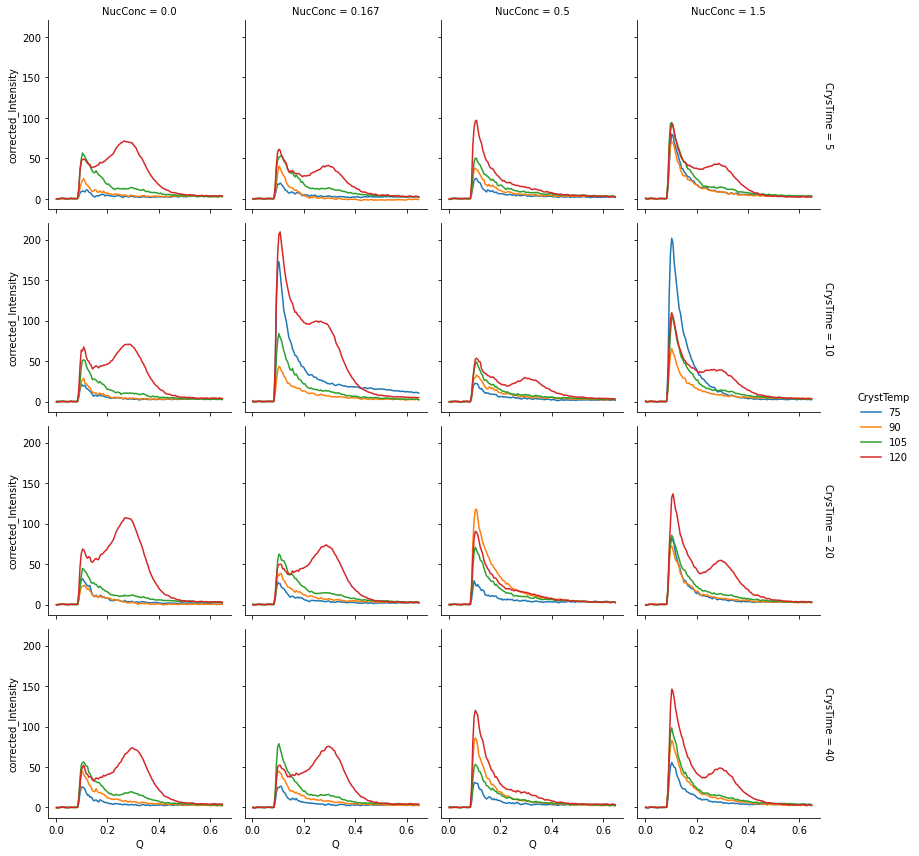

In [11]:
##### 一定の値で引くと？ #####
peakcor_saxs=pd.merge(saxs_data, sair.drop("SampleNo",axis=1)).merge(coef_list_wp)\
    .eval('corrected_Intensity = Intensity-  airIntensity*.9')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
peakcor_saxs.to_csv(PATH+"/corrected_data/saxs_peakcorrect.csv")
#補正後
grid = sns.FacetGrid(data=peakcor_saxs, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

             Q  SampleNo  CrystTemp  CrysTime  NucConc  min_coef  \
0     0.002407        17         75         5      0.0  0.315452   
64    0.007221        17         75         5      0.0  0.315452   
128   0.012035        17         75         5      0.0  0.315452   
192   0.016849        17         75         5      0.0  0.315452   
256   0.021663        17         75         5      0.0  0.315452   
...        ...       ...        ...       ...      ...       ...   
8383  0.628230        80        120        40      1.5  0.583310   
8447  0.633044        80        120        40      1.5  0.583310   
8511  0.637858        80        120        40      1.5  0.583310   
8575  0.642672        80        120        40      1.5  0.583310   
8639  0.647486        80        120        40      1.5  0.583310   

      corrected_Intensity  
0                0.000000  
64               0.079726  
128              0.335102  
192              0.580735  
256              0.618285  
...            

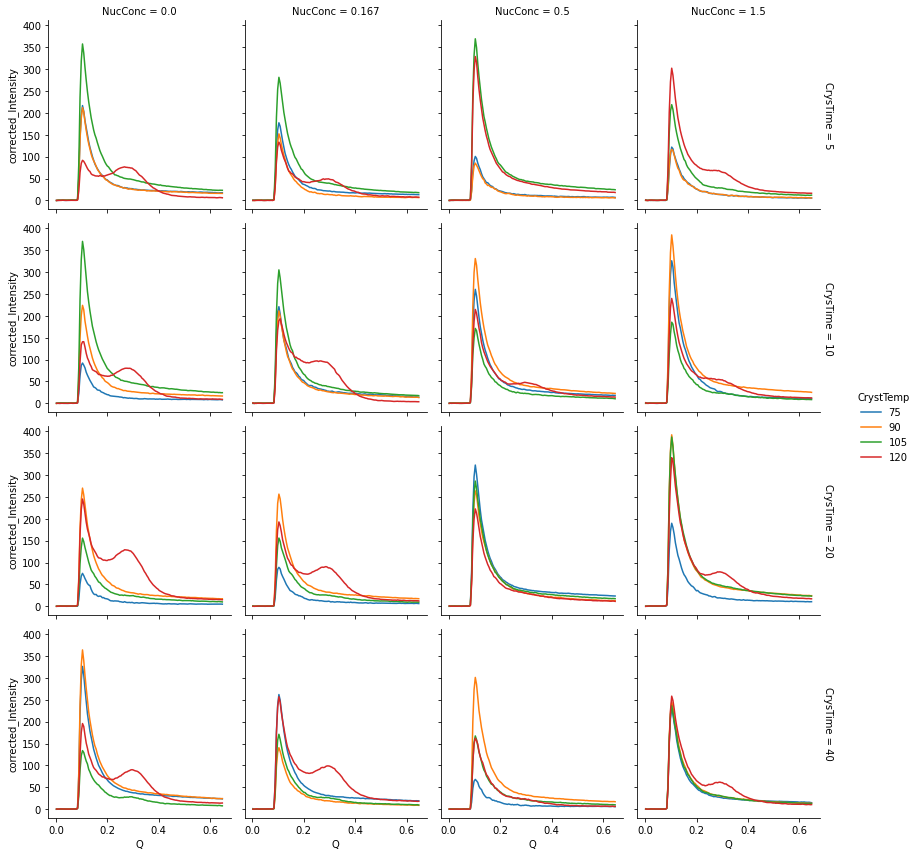

In [12]:
#####min correct (負のIntensityが生まれないように補正) #####
coef_list_sm=pd.merge(saxs_data, sair.drop("SampleNo",axis=1))\
    .eval("min_coef=Intensity/airIntensity").dropna()\
    .groupby('SampleNo').agg({'min_coef':min})

mincor_saxs=pd.merge(saxs_data, sair.drop("SampleNo",axis=1)).merge(coef_list_sm,left_on='SampleNo',right_index=True)\
    .eval('corrected_Intensity = Intensity- min_coef * airIntensity')\
    .drop(['Intensity', 'airIntensity', 'Cooling'], axis=1)
print(mincor_saxs)
mincor_saxs.to_csv(PATH+"/corrected_data/saxs_mincorrect.csv")
#補正後
grid = sns.FacetGrid(data=mincor_saxs, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()

## min correct じゃ全然ダメ、、、 ##  
  
## peak correctでairを取り除いた後  IallでIntensityを補正 ##  
**Iallの補正はSAXSにもWAXDの補正値を使用する**

In [13]:
#補正値の算出
Iall_mean=np.mean(peakcor_waxd["corrected_Intensity"])
Iall_coef=peakcor_waxd.groupby('SampleNo').agg(Iall=("corrected_Intensity","mean"))\
    .eval('Iall_coef=@Iall_mean / Iall').drop('Iall',axis=1)
Iall_coef.T

SampleNo,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80
Iall_coef,0.639228,0.988414,1.167511,1.13799,0.917943,0.934113,1.067026,0.974015,0.845744,1.001282,1.124019,0.864135,0.980593,1.048011,1.034274,0.938157,0.836892,1.141626,1.024409,0.855913,1.087834,1.167705,1.123393,0.948738,0.944216,...,1.105097,1.162622,0.980374,1.115217,0.873392,0.863817,1.038712,0.743373,0.88398,1.130653,1.284721,1.062256,1.756823,1.247021,1.159741,1.230809,1.036878,1.20124,1.027378,1.221125,1.000316,0.939738,0.872975,0.977687,1.274102


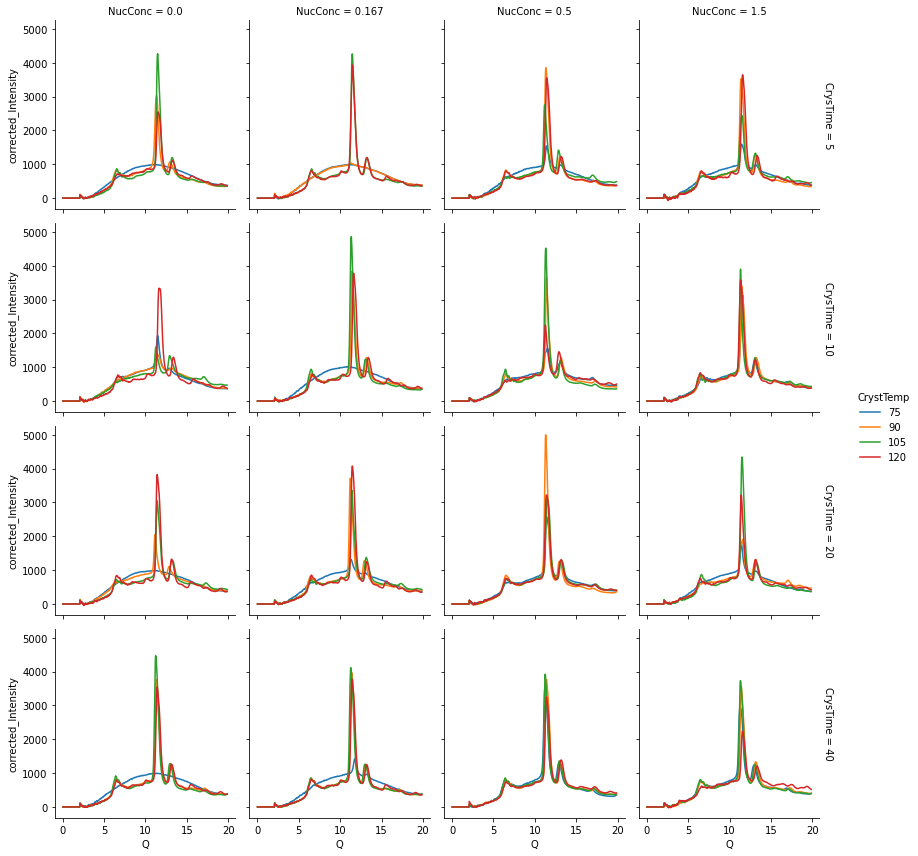

In [14]:
corrected_waxd=peakcor_waxd.set_index('SampleNo')\
    .merge(Iall_coef,left_index=True,right_index=True)\
    .eval('corrected_Intensity=corrected_Intensity*Iall_coef')
corrected_waxd.to_csv(PATH+"/corrected_data/waxd_corrected.csv")

grid = sns.FacetGrid(data=corrected_waxd, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()
plt.savefig("../fig/Xray_correction/WAXD_Iallcorrect.pdf")

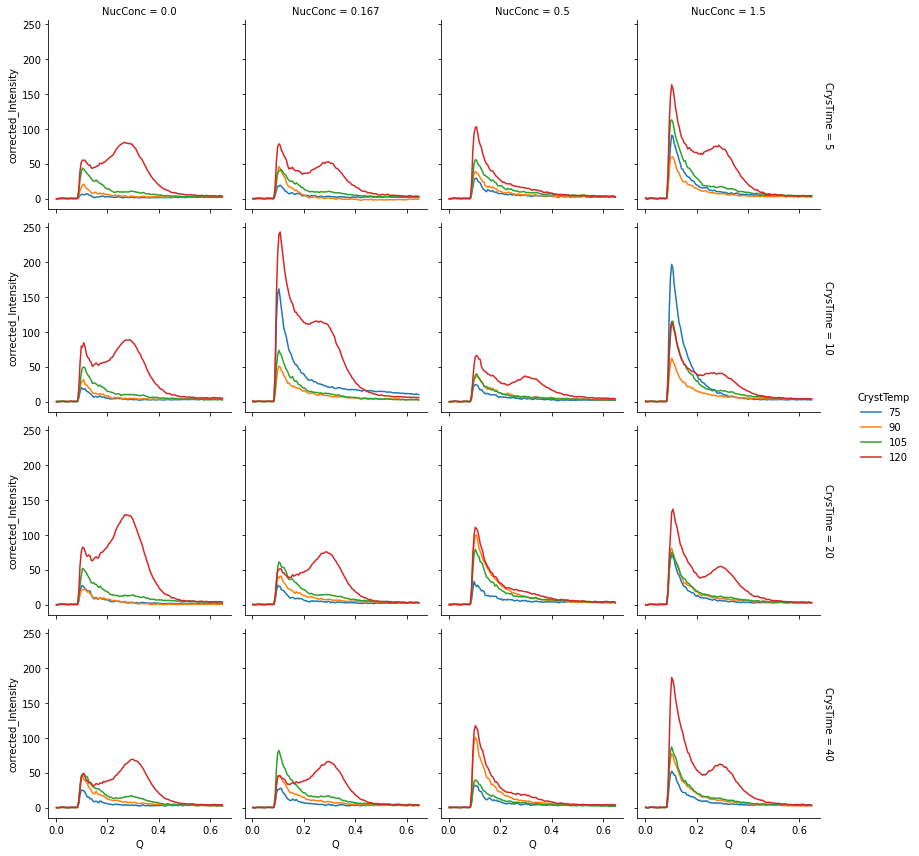

In [15]:
corrected_saxs=peakcor_saxs.set_index('SampleNo')\
    .merge(Iall_coef,left_index=True,right_index=True)\
    .eval('corrected_Intensity=corrected_Intensity*Iall_coef')
corrected_saxs.to_csv(PATH+"/corrected_data/saxs_corrected.csv")

grid = sns.FacetGrid(data=corrected_saxs, col='NucConc', row='CrysTime', hue ='CrystTemp',margin_titles=True)
grid.map(sns.lineplot, 'Q', 'corrected_Intensity').add_legend()
plt.savefig("../fig/Xray_correction/SAXS_Iallcorrect.pdf")